In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np
import os
from sklearn import datasets
import matplotlib.pyplot as plt
import random

from mlp import MLP
from modules import CrossEntropy

In [4]:
# Default constants
DNN_HIDDEN_UNITS_DEFAULT = '20'
LEARNING_RATE_DEFAULT = 1e-2
MAX_EPOCHS_DEFAULT = 1500
EVAL_FREQ_DEFAULT = 10

FLAGS = None 

#### The variable to specify BGD or SGD you will use:
If you want to use BGD, set the value as "BGD"; or if you want SGD, set the value as "SGD".

In [5]:
flag_bgd_sgd = "SGD" 

In [6]:
# Generate dataset
x,t = datasets.make_moons(1000)

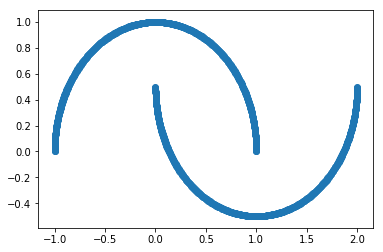

In [7]:
# Show how x looks
plt.scatter(x[:,0],x[:,1])

In [8]:
# Convert t to one-hot
def convert_to_one_hot(y, C):
    return np.eye(C)[y.reshape(-1)]
    
t = convert_to_one_hot(t,2)

# Devide training data and test data
train_x = x[:800]
train_t = t[:800]
test_x = x[800:]
test_t = t[800:]

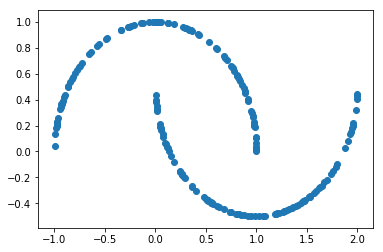

In [9]:
# Show how test data x looks
plt.scatter(test_x[:,0],test_x[:,1])

In [10]:
def accuracy(predictions, targets, flag):
    """
    Computes the prediction accuracy, i.e., the average of correct predictions
    of the network.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        labels: 2D int array of size [number_of_data_samples, n_classes] with one-hot encoding of ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """
    n_accu = 0

    if flag == "train":
        for i in range(len(predictions)):
      
            if predictions[i][0][0] > predictions[i][0][1] and targets[i][0][0] > targets[i][0][1]:
                n_accu = n_accu + 1
            elif predictions[i][0][0] < predictions[i][0][1] and targets[i][0][0] < targets[i][0][1]:
                n_accu = n_accu + 1
    elif flag == "test":
        for i in range(len(predictions)):
            if predictions[i][0][0] > predictions[i][0][1] and targets[i][0] > targets[i][1]:
                n_accu = n_accu + 1
            elif predictions[i][0][0] < predictions[i][0][1] and targets[i][0] < targets[i][1]:
                n_accu = n_accu + 1

    accuracy = n_accu/len(predictions)
    return accuracy

### Batch Gradient Descent:
This function will return three arrays to show the accuracy curves for both training and test data and trend of loss: 
- *accu_train*: It records the accuracy of training data each eval_freq iterations.
- *accu_test*: It records the accuracy of training data each eval_freq iterations.
- *losses*: It records a loss every epoch.

In [11]:
def BGD_train():
    """
    Performs training and evaluation of MLP model.
    NOTE: You should evaluate the model on the whole test set each eval_freq iterations.
    """
    # YOUR TRAINING CODE GOES HERE
    # Define parameters passed to MLP()
    n_inputs = len(train_x[0])
    
    n_hidden = list(map(int, DNN_HIDDEN_UNITS_DEFAULT.split()))

    n_classes = len(train_t[0])
    
    # Define a MLP Object
    mlp = MLP(n_inputs, n_hidden, n_classes)

    # train   
    predictions_train = []
    labels_train = []
    accu_train = []
    losses = []

    for i in range(MAX_EPOCHS_DEFAULT):


        if i != 0 and i % EVAL_FREQ_DEFAULT == 0:
            accu = accuracy(predictions_train, labels_train, "train")
            accu_train.append(accu)
            predictions_train = []
            labels_train = []

        for i in range(len(train_x)):
            input_x = train_x[i].reshape(1,-1)
            label_t = train_t[i].reshape(1,-1)
            out = mlp.forward(input_x)
            loss = CrossEntropy().forward(out, label_t)
            mlp.backward(out, label_t)

        for i in range(len(n_hidden)+1):
 
            mlp.linear_layers[i].params['weight'] = mlp.linear_layers[i].params['weight'] - LEARNING_RATE_DEFAULT * (mlp.linear_layers[i].sum_grads['weight'] / len(train_x))
            mlp.linear_layers[i].params['bias'] = mlp.linear_layers[i].params['bias'] - LEARNING_RATE_DEFAULT * (mlp.linear_layers[i].sum_grads['bias'] / len(train_x))
            mlp.linear_layers[i].sum_grads['weight']  = np.zeros((mlp.linear_layers[i].in_features, mlp.linear_layers[i].out_features))
            mlp.linear_layers[i].sum_grads['bias'] = 0
         
        
        losses.append(loss)
        predictions_train.append(out)
        labels_train.append(label_t)
    
    
    # test
    predictions_test = []
    labels_test = []
    accu_test = []
    
    for i in range(len(test_x)):
        if i != 0 and i % EVAL_FREQ_DEFAULT == 0:
            accu = accuracy(predictions_test, labels_test, "test")
            accu_test.append(accu)
            predictions_test = []
            labels_test = []
        
        input_x = test_x[i]
        label_t = test_t[i]
        
        out = mlp.forward(input_x)
        
        predictions_test.append(out)
        labels_test.append(label_t)
        
    return accu_train, accu_test, losses


### Stochastic Gradient Descent:
This function will return three arrays to show the accuracy curves for both training and test data and trend of loss: 
- *accu_train*: It records the accuracy of training data each eval_freq iterations.
- *accu_test*: It records the accuracy of training data each eval_freq iterations.
- *losses*: It records a loss every epoch.

In [12]:
def SGD_train():
    """
    Performs training and evaluation of MLP model.
    NOTE: You should evaluate the model on the whole test set each eval_freq iterations.
    """
    # YOUR TRAINING CODE GOES HERE

    # Define parameters passed to MLP()
    n_inputs = len(train_x[0])
    
    n_hidden = list(map(int, DNN_HIDDEN_UNITS_DEFAULT.split()))

    n_classes = len(train_t[0])
    
    # Define a MLP Object
    mlp = MLP(n_inputs, n_hidden, n_classes)

    # train
    predictions_train = []
    labels_train = []
    accu_train = []
    losses = []

    for i in range(MAX_EPOCHS_DEFAULT):
      

        if i != 0 and i % EVAL_FREQ_DEFAULT == 0:
            accu = accuracy(predictions_train, labels_train, "train")
            accu_train.append(accu)
            predictions_train = []
            labels_train = []

        randnum = random.randint(0,100)
        random.seed(randnum)
        random.shuffle(train_x)
        random.seed(randnum)
        random.shuffle(train_t)
        for i in range(len(train_x)):
            input_x = train_x[i].reshape(1,-1)
            label_t = train_t[i].reshape(1,-1)
            out = mlp.forward(input_x)
            loss = CrossEntropy().forward(out, label_t)
            mlp.backward(out, label_t)
            for l in mlp.linear_layers:
                l.params['weight'] = l.params['weight'] - LEARNING_RATE_DEFAULT * l.grads['weight']
                l.params['bias'] = l.params['bias'] - LEARNING_RATE_DEFAULT * l.grads['bias']
        losses.append(loss)
        predictions_train.append(out)
        labels_train.append(label_t)

    
    # test
    predictions_test = []
    labels_test = []
    accu_test = []
    
    for i in range(len(test_x)):
        if i != 0 and i % EVAL_FREQ_DEFAULT == 0:
            accu = accuracy(predictions_test, labels_test, "test")
            accu_test.append(accu)
            predictions_test = []
            labels_test = []
        
        input_x = test_x[i]
        label_t = test_t[i]
        
        out = mlp.forward(input_x)
        
        predictions_test.append(out)
        labels_test.append(label_t)
    

    return accu_train, accu_test, losses

In [13]:
def draw_figure(accu_train, accu_test, losses):

    plt.title('Accuracy of Training Data and Testing Data')
    
    plt.plot(accu_train, color='red', label='training accuracy')
    
    plt.plot(accu_test, color='green', label='testing accuracy')
    
    plt.xlabel('Sample Time')
    
    plt.ylabel('Accuracy')
    
    plt.legend()
    
    plt.show()
    
    plt.title('Loss Trend')
    
    plt.plot(losses)
    
    plt.xlabel('Epoch')
    
    plt.ylabel('Loss')
    
    plt.show()
    

In [14]:
def main(flag_bgd_sgd):
    """
    Main function
    """ 
    if flag_bgd_sgd == "SGD":
        accu_train, accu_test, losses = SGD_train()
    elif flag_bgd_sgd == "BGD":
        accu_train, accu_test, losses = BGD_train()
    
    draw_figure(accu_train, accu_test, losses)

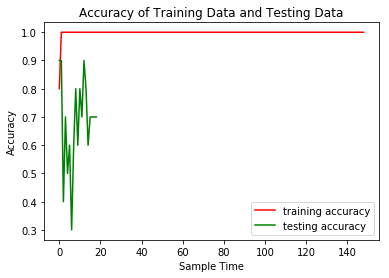

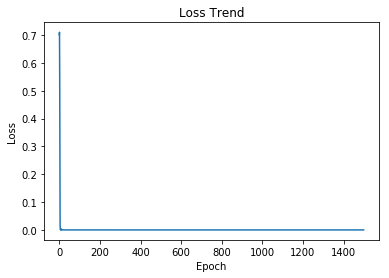

In [15]:
if __name__ == '__main__':
    # Command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--dnn_hidden_units', type = str, default = DNN_HIDDEN_UNITS_DEFAULT,
                      help='Comma separated list of number of units in each hidden layer')
    parser.add_argument('--learning_rate', type = float, default = LEARNING_RATE_DEFAULT,
                      help='Learning rate')
    parser.add_argument('--max_steps', type = int, default = MAX_EPOCHS_DEFAULT,
                      help='Number of epochs to run trainer.')
    parser.add_argument('--eval_freq', type=int, default=EVAL_FREQ_DEFAULT,
                          help='Frequency of evaluation on the test set')
    FLAGS, unparsed = parser.parse_known_args()
    main(flag_bgd_sgd)

# Note:
**Both train_mlp_numpy_BGD.ipynb and train_mlp_numpy_SGD.ipynb can specify which training method to use, w.r.t. BGD or SGD. I create these two files just to show the different results of BGD and SGD. So in this ipynb, the result of SGD is shown here.**